<a href="https://colab.research.google.com/github/87tana/Image-Segmentation/blob/main/Tumor_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up environment

In [2]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [3]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [46]:
# Path to the JSON file
train_annotations_path = 'Tumor_Segmentation/train/_annotations.coco.json'
valid_annotations_path = 'Tumor_Segmentation/valid/_annotations.coco.json'
test_annotations_path = 'Tumor_Segmentation/test/_annotations.coco.json'

# Path to image directories
image_data_paths = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'
train_img_path = 'Tumor_Segmentation/train'
valid_img_path = 'Tumor_Segmentation/valid'
test_img_path = 'Tumor_Segmentation/test'

In [7]:
import os
import cv2
import json
import random
from PIL import Image
import pandas as pd
import numpy as np
import skimage.draw

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import skimage  # import scikit_image
import tifffile  # for reading and writing TIFF
import shutil #Higher-level interface for file operations, including file copying, removal, and archiving


# 2. Data Prepration

## 2.1. Creating DataFrame

In [8]:
file_name = []
width = []
height = []
category_id = []
segmentation = []
subset = []

for s in ['train', 'valid', 'test']:
  with open('Tumor_Segmentation/'+s+'/_annotations.coco.json','r') as file:
    data = json.load(file)
    for id in range(len(data['images'])):
      # Flag to check the annotation availability
      ann_available=False
      # Look for the corresponding annotation
      for j in range(id,len(data['images'])):
        if data['annotations'][j]['image_id'] == data['images'][id]['id']:
          category_id.append(data['annotations'][j]['category_id'])
          segmentation.append(data['annotations'][j]['segmentation'])
          ann_available=True
          break

      if ann_available:
        file_name.append(data['images'][id]['file_name'])
        width.append(data['images'][id]['width'])
        height.append(data['images'][id]['height'])
        subset.append(s)
      else:
        print(f'Annotation is missing for image {id} in {s}')



dic = {'file_name': file_name, 'width': width , 'height': height,\
        'category_id': category_id, 'segmentation': segmentation, 'subset': subset}



Annotation is missing for image 1380 in train


To handle the dataset, we initialize a dataframe and extract crucial details from it. This involves parsing annotations stored in JSON files for each subset of the dataset (train, valid, test). For each image, the program locates the corresponding annotation, retrieves pertinent data, and organizes it into lists. In case an annotation is absent for an image, a warning message is printed. Finally, a dictionary named 'dic' is constructed, consolidating all the extracted information.

In [9]:
df = pd.DataFrame.from_dict(dic)
df.head()

,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",train
2,2921_jpg.rf.3b952f91f27a6248091e7601c22323ad.jpg,640,640,1,"[[295, 172.5, 132.5, 172.5, 132.5, 357.5, 295,...",train
3,2777_jpg.rf.3b60ea7f7e70552e70e41528052018bd.jpg,640,640,1,"[[383.75, 357.5, 245, 357.5, 245, 523.75, 383....",train
4,2860_jpg.rf.3bb87fa4f938af5abfb1e17676ec1dad.jpg,640,640,1,"[[192.5, 188.75, 80, 188.75, 80, 321.25, 192.5...",train


In [51]:
def create_mask(image_info):
  mask_np = np.zeros((image_info['height'],image_info['width']),dtype=np.uint8)

  for seg_idx ,seg in enumerate(image_info['segmentation']):
      rr, cc = skimage.draw.polygon(seg[1::2], seg[0::2], mask_np.shape)
      mask_np[rr,cc]=1

  return mask_np

## 2.2 Training Data Images Glimpse, Class 1 (no tumor) and Class 2 (Tumor)

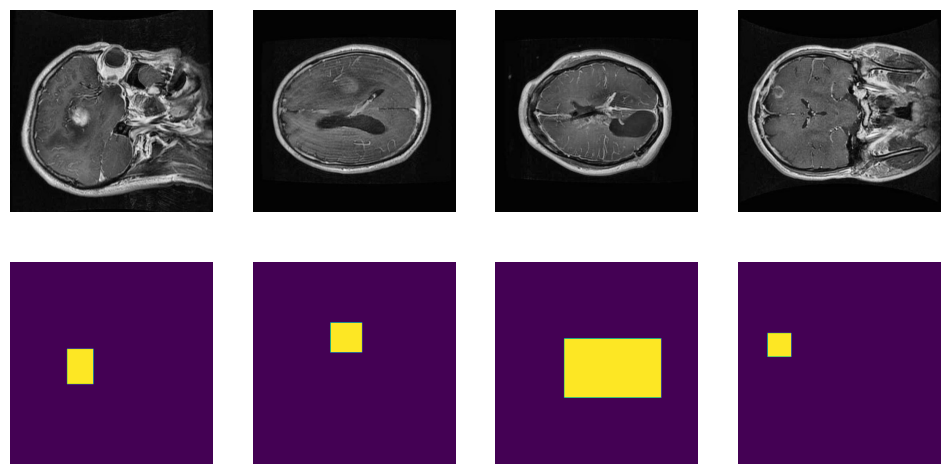

In [52]:
samp = df[df['category_id']==1].sample(4).reset_index(drop=True)

fig, axes = plt.subplots (2,4,figsize=(12,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(image_data_paths,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()
